## Global Ratio of Created versus Modified Buildings

In [1]:
start_year = 2018
filter_keyword = 'microsoft/BuildingFootprints'
data_path = "/data/processing/partitioned-ohsome-parquet-100997/visible=*/year=*/*.parquet"


sql = f"""
COPY
(
    -- analyse if a contribution has been updated again
    WITH new_osm_ids AS (
        SELECT
          osm_id
          ,tags
          ,changeset_tags
          ,contrib_type
          ,CASE
            WHEN contains(tags['source'][1], '{filter_keyword}') THEN 1
            ELSE 0
          END AS source_microsoft
        FROM read_parquet("{data_path}", hive_partitioning=1)
        WHERE
            year >= {start_year}
            AND
            tags['building'][1] is not null
            AND
            contrib_type = 'CREATED'
            AND
            osm_type = 'way'
    ),
    -- aggregate by osm id
    new_osm_ids_agg as (
    SELECT
        a.osm_id
        ,min(to_timestamp(b.changeset_timestamp/1000)) as creation_timestamp
        ,max(source_microsoft) as source_microsoft
        ,array_agg(b.contrib_type) as contrib_types
        ,array_agg(to_timestamp(b.changeset_timestamp/1000)) as changeset_timestamps
        ,len(array_agg(b.contrib_type)) as n_contributions
    FROM new_osm_ids as a
    LEFT JOIN read_parquet("{data_path}", hive_partitioning=1) as b ON
        a.osm_id = b.osm_id
    WHERE b.year >= {start_year}
    GROUP BY a.osm_id
    )
    SELECT
        source_microsoft
        ,date_trunc('year', creation_timestamp) as creation_year
        ,count(*) as all_ways
        ,SUM(CASE when n_contributions > 1 THEN 1 ELSE 0 END) as modified_ways
        ,SUM(CASE when n_contributions > 1 THEN 1 ELSE 0 END) / count(*) modified_ways_share
        ,AVG(n_contributions) as avg_n_contributions
    FROM new_osm_ids_agg
    GROUP BY source_microsoft, creation_year
    ORDER BY source_microsoft, creation_year
)
TO 'contribution_pattern_global.csv' (HEADER, DELIMITER ',');
"""
print(sql)


COPY
(
    -- analyse if a contribution has been updated again
    WITH new_osm_ids AS (
        SELECT
          osm_id
          ,tags
          ,changeset_tags
          ,contrib_type
          ,CASE
            WHEN contains(tags['source'][1], 'microsoft/BuildingFootprints') THEN 1
            ELSE 0
          END AS source_microsoft
        FROM read_parquet("/data/processing/partitioned-ohsome-parquet-100997/visible=*/year=*/*.parquet", hive_partitioning=1)
        WHERE
            year >= 2018
            AND
            tags['building'][1] is not null
            AND
            contrib_type = 'CREATED'
            AND
            osm_type = 'way'
    ),
    -- aggregate by osm id
    new_osm_ids_agg as (
    SELECT
        a.osm_id
        ,min(to_timestamp(b.changeset_timestamp/1000)) as creation_timestamp
        ,max(source_microsoft) as source_microsoft
        ,array_agg(b.contrib_type) as contrib_types
        ,array_agg(to_timestamp(b.changeset_timestamp/1000)) as cha

Run the script above in duckdb and upload the file to GitHub. 
Then continue with the steps below.

In [1]:
import pandas as pd
import datetime

In [2]:
# create a plot of the results
df = pd.read_csv("../data/contribution_pattern_global.csv")
df["creation_year"] = pd.to_datetime(df["creation_year"])
df["label"] = "non-AI"
df.loc[df["source_microsoft"] == 1 , "label"] = "AI-generated"
df["modified_ways_share"] = 100 * df["modified_ways_share"] 
display(df)

,source_microsoft,creation_year,all_ways,modified_ways,modified_ways_share,avg_n_contributions,label
0,0,2018-01-01 00:00:00+00:00,66862994,19690329,29.448770,1.413995,non-AI
1,0,2019-01-01 00:00:00+00:00,48659489,14827426,30.471808,1.421879,non-AI
2,0,2020-01-01 00:00:00+00:00,58906128,18200697,30.897799,1.410427,non-AI
3,0,2021-01-01 00:00:00+00:00,61699117,13496034,21.873950,1.293718,non-AI
4,0,2022-01-01 00:00:00+00:00,51017012,8637165,16.929970,1.213124,non-AI
5,0,2023-01-01 00:00:00+00:00,42390042,6978491,16.462572,1.202119,non-AI
6,0,2024-01-01 00:00:00+00:00,10120665,794187,7.847182,1.089854,non-AI
7,1,2019-01-01 00:00:00+00:00,14273,4069,28.508372,1.319624,AI-generated
8,1,2020-01-01 00:00:00+00:00,2693139,693733,25.759272,1.331499,AI-generated
9,1,2021-01-01 00:00:00+00:00,3531430,976038,27.638605,1.365876,AI-generated


In [3]:
# add data without considering USA
# create a plot of the results
df_countries = pd.read_csv("../data/contribution_pattern_per_country.csv")
df_countries["creation_year"] = pd.to_datetime(df_countries["creation_year"])
df_countries["label"] = "non-AI (without USA)"
df_countries.loc[df_countries["source_microsoft"] == 1 , "label"] = "AI-generated (without USA)"

df_without_usa = df_countries[
    (df_countries["country_iso_a3"] != 'USA')
    &
    (df_countries["creation_year"] > '2019-01-01')
]
df_without_usa_grouped = df_without_usa.groupby(["source_microsoft", "label", "creation_year"]).agg(
    modified_ways = pd.NamedAgg(column="modified_ways", aggfunc="sum"),
    all_ways = pd.NamedAgg(column="all_ways", aggfunc="sum"),
)

df_without_usa_grouped["modified_ways_share"] = 100 * df_without_usa_grouped["modified_ways"] / df_without_usa_grouped["all_ways"]
display(df_without_usa_grouped)

modified_ways  \
source_microsoft label                      creation_year                              
0                non-AI (without USA)       2020-01-01 00:00:00+00:00       16452327   
                                            2021-01-01 00:00:00+00:00       12627173   
                                            2022-01-01 00:00:00+00:00        7965934   
                                            2023-01-01 00:00:00+00:00        6202212   
                                            2024-01-01 00:00:00+00:00         752431   
1                AI-generated (without USA) 2020-01-01 00:00:00+00:00          73548   
                                            2021-01-01 00:00:00+00:00          36894   
                                            2022-01-01 00:00:00+00:00         509163   
                                            2023-01-01 00:00:00+00:00         516863   
                                            2024-01-01 00:00:00+00:00         180817   

                                                                       all_ways  \
source_microsoft label                      creation_year                         
0                non-AI (without USA)       2020-01-01 00:00:00+00:00  53352866   
                                            2021-01-01 00:00:00+00:00  56373545   
                                            2022-01-01 00:00:00+00:00  45080160   
                                            2023-01-01 00:00:00+00:00  39005643   
                                            2024-01-01 00:00:00+00:00   9514002   
1                AI-generated (without USA) 2020-01-01 00:00:00+00:00    282275   
                                            2021-01-01 00:00:00+00:00    361168   
                                            2022-01-01 00:00:00+00:00   3588018   
                                            2023-01-01 00:00:00+00:00   5456453   
                                            2024-01-01 00:00:00+00:00   1700252   

                                                                       modified_ways_share  
source_microsoft label                      creation_year                                   
0                non-AI (without USA)       2020-01-01 00:00:00+00:00            30.836820  
                                            2021-01-01 00:00:00+00:00            22.399111  
                                            2022-01-01 00:00:00+00:00            17.670598  
                                            2023-01-01 00:00:00+00:00            15.900807  
                                            2024-01-01 00:00:00+00:00             7.908670  
1                AI-generated (without USA) 2020-01-01 00:00:00+00:00            26.055442  
                                            2021-01-01 00:00:00+00:00            10.215191  
                                            2022-01-01 00:00:00+00:00            14.190648  
                                            2023-01-01 00:00:00+00:00             9.472509  
                                            2024-01-01 00:00:00+00:00            10.634718

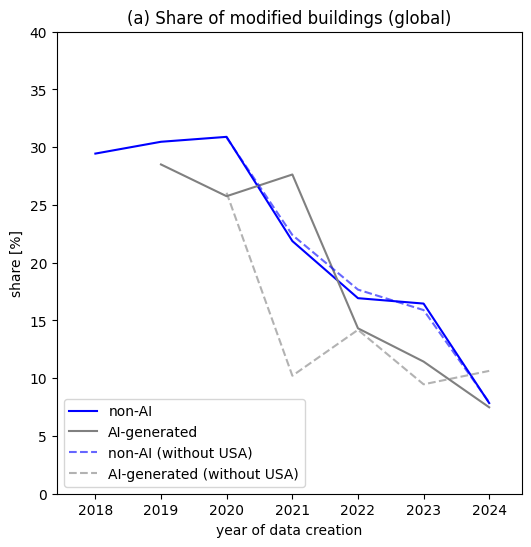

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))

sns.lineplot(
    x='creation_year', 
    y='modified_ways_share',
    hue='label', 
    data=df,
    palette=['blue', 'grey'],
)

sns.lineplot(
    x='creation_year', 
    y='modified_ways_share',
    hue='label', 
    data=df_without_usa_grouped,
    linestyle='--',
    palette=['blue', 'grey'],
    alpha=0.6
)

plt.ylim((0, 40))
plt.xlim((
    datetime.datetime(2017,6,1),
    datetime.datetime(2024,7,1)
))
plt.ylabel("share [%]")
plt.xlabel("year of data creation")
plt.legend(loc="lower left")
plt.title("(a) Share of modified buildings (global)")
plt.savefig(
    "../plots/contribution_pattern_global.png",
    bbox_inches='tight',
    dpi=300
)
plt.show()

## Contribution Pattern per Country

In [10]:
start_year = 2018
filter_keyword = 'microsoft/BuildingFootprints'
data_path = "/data/processing/partitioned-ohsome-parquet-100997/visible=*/year=*/*.parquet"


sql = f"""
COPY
(
    -- analyse if a contribution has been updated again
    WITH new_osm_ids AS (
        SELECT
          osm_id
          ,tags
          ,changeset_tags
          ,contrib_type
          ,unnest(country_iso_a3) as country_iso_a3
          ,CASE
            WHEN contains(tags['source'][1], '{filter_keyword}') THEN 1
            ELSE 0
          END AS source_microsoft
        FROM read_parquet("{data_path}", hive_partitioning=1)
        WHERE
            year >= {start_year}
            AND
            tags['building'][1] is not null
            AND
            contrib_type = 'CREATED'
            AND
            osm_type = 'way'
    ),
    -- aggregate by osm id
    new_osm_ids_agg as (
    SELECT
        a.osm_id
        ,a.country_iso_a3
        ,min(to_timestamp(b.changeset_timestamp/1000)) as creation_timestamp
        ,max(source_microsoft) as source_microsoft
        ,array_agg(b.contrib_type) as contrib_types
        ,array_agg(to_timestamp(b.changeset_timestamp/1000)) as changeset_timestamps
        ,len(array_agg(b.contrib_type)) as n_contributions
    FROM new_osm_ids as a
    LEFT JOIN read_parquet("{data_path}", hive_partitioning=1) as b ON
        a.osm_id = b.osm_id
    WHERE b.year >= {start_year}
    GROUP BY a.osm_id, a.country_iso_a3
    )
    SELECT
        country_iso_a3
        ,source_microsoft
        ,date_trunc('year', creation_timestamp) as creation_year
        ,count(*) as all_ways
        ,SUM(CASE when n_contributions > 1 THEN 1 ELSE 0 END) as modified_ways
        ,SUM(CASE when n_contributions > 1 THEN 1 ELSE 0 END) / count(*) modified_ways_share
        ,AVG(n_contributions) as avg_n_contributions
    FROM new_osm_ids_agg
    GROUP BY country_iso_a3, source_microsoft, creation_year
    ORDER BY country_iso_a3, source_microsoft, creation_year
)
TO 'contribution_pattern_per_country.csv' (HEADER, DELIMITER ',');
"""
print(sql)


COPY
(
    -- analyse if a contribution has been updated again
    WITH new_osm_ids AS (
        SELECT
          osm_id
          ,tags
          ,changeset_tags
          ,contrib_type
          ,unnest(country_iso_a3) as country_iso_a3
          ,CASE
            WHEN contains(tags['source'][1], 'microsoft/BuildingFootprints') THEN 1
            ELSE 0
          END AS source_microsoft
        FROM read_parquet("/data/processing/partitioned-ohsome-parquet-100997/visible=*/year=*/*.parquet", hive_partitioning=1)
        WHERE
            year >= 2018
            AND
            tags['building'][1] is not null
            AND
            contrib_type = 'CREATED'
            AND
            osm_type = 'way'
    ),
    -- aggregate by osm id
    new_osm_ids_agg as (
    SELECT
        a.osm_id
        ,a.country_iso_a3
        ,min(to_timestamp(b.changeset_timestamp/1000)) as creation_timestamp
        ,max(source_microsoft) as source_microsoft
        ,array_agg(b.contrib_type) as con

In [5]:
# create a plot of the results
df = pd.read_csv("../data/contribution_pattern_per_country.csv")
df["creation_year"] = pd.to_datetime(df["creation_year"])
df["label"] = "non-AI"
df.loc[df["source_microsoft"] == 1 , "label"] = "AI (Microsoft Buildings)"
df["modified_ways_share"] = 100 * df["modified_ways_share"]
display(df)

,country_iso_a3,source_microsoft,creation_year,all_ways,modified_ways,modified_ways_share,avg_n_contributions,label
0,AFG,0,2018-01-01 00:00:00+00:00,18950,17039,89.915567,2.078047,non-AI
1,AFG,0,2019-01-01 00:00:00+00:00,21756,12808,58.871116,1.707529,non-AI
2,AFG,0,2020-01-01 00:00:00+00:00,355956,125903,35.370383,1.502155,non-AI
3,AFG,0,2021-01-01 00:00:00+00:00,1044029,79643,7.628428,1.080376,non-AI
4,AFG,0,2022-01-01 00:00:00+00:00,252003,34342,13.627616,1.150820,non-AI
...,...,...,...,...,...,...,...,...
1959,ZWE,0,2023-01-01 00:00:00+00:00,62055,9322,15.022158,1.157393,non-AI
1960,ZWE,0,2024-01-01 00:00:00+00:00,1357,27,1.989683,1.024318,non-AI
1961,ZWE,1,2022-01-01 00:00:00+00:00,121,0,0.000000,1.000000,AI (Microsoft Buildings)
1962,ZWE,1,2023-01-01 00:00:00+00:00,1964,970,49.389002,1.500509,AI (Microsoft Buildings)


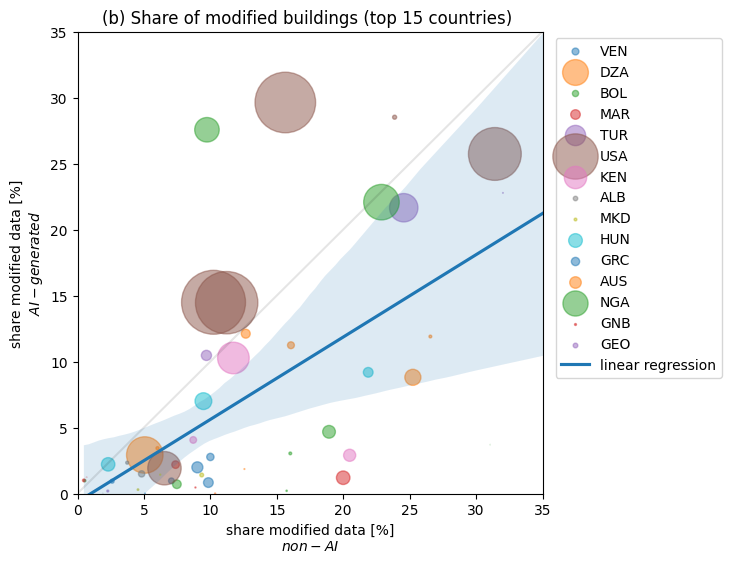

In [6]:
from sklearn.linear_model import LinearRegression
import numpy as np


top_15_countries_percentage = [
    'VEN',
    'DZA',
    'BOL',
    'MAR',
    'TUR',
    'USA',
    'KEN',
    'ALB',
    'MKD',
    'HUN',
    'GRC',
    'AUS',
    'NGA',
    'GNB',
    'GEO'
]


x_list = []
y_list = []
weights_list = []

plt.figure(figsize=(6,6))
plt.plot(
    [0,35],
    [0,35],
    linestyle='-',
    color='black',
    alpha=0.1
)

for country in top_15_countries_percentage:
    df_filtered_ai = df[
        (df["country_iso_a3"] == country)
        &
        (df["source_microsoft"] == 1)
    ]
    years_with_ai = df_filtered_ai["creation_year"].to_list()

    df_filtered_non_ai = df[
        (df["country_iso_a3"] == country)
        &
        (df["source_microsoft"] == 0)
        &
        (df["creation_year"].isin(years_with_ai))
    ]

    x = df_filtered_non_ai["modified_ways_share"].to_numpy()
    y = df_filtered_ai["modified_ways_share"].to_numpy()
    
    plt.scatter(
        x,
        y,
        s=0.6 * df_filtered_ai["all_ways"] / 10**3,
        alpha=0.5,
        label=country
    )

    x_list += list(x)
    y_list += list(y)
    weights_list += df_filtered_ai["all_ways"].to_list()


sns.regplot(
    x=x_list,
    y=y_list,
    scatter=False,
    label="linear regression"
)

plt.legend(
    loc='upper right',
    bbox_to_anchor=(1.4, 1)
)
plt.title("(b) Share of modified buildings (top 15 countries) ")
plt.xlabel("share modified data [%]\n$\it{non-AI}$")
plt.ylabel("share modified data [%]\n$\it{AI-generated}$")
plt.xlim((0, 35))
plt.ylim((0, 35))
plt.savefig(
    "../plots/contribution_pattern_per_country_scatter.png",
    bbox_inches='tight',
    dpi=300
)
plt.show()